In [1]:
%matplotlib inline

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import starry
import warnings
from scipy.special import legendre
from scipy.integrate import quad


warnings.filterwarnings("ignore")
starry.config.lazy = False
starry.config.quiet = True

/opt/anaconda3/envs/starry-env/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/envs/starry-env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def phi(y, r=np.inf):
    return np.arcsin(y) + 2 * (1 - np.sqrt(1 - y ** 2)) / (y * r)

def transform(x, y, rs=np.inf):
    # Radial coordinate on disk
    rho = np.sqrt(x ** 2 + y ** 2)
    
    # Angular coordinate on disk (conserved)
    t = np.arctan2(y, x)

    # z coordinate on sphere
    z_ = np.cos(phi(rho, rs))

    # Compute x and y from conserved angle
    x_ = np.sign(x) * np.sqrt((1 - z_ ** 2) / (1 + np.tan(t) ** 2))
    y_ = np.sign(y) * np.sqrt(1 - x_ ** 2 - z_ ** 2)

    # Conver to lat-lon
    lat = np.arcsin(y_)
    lon = np.arctan2(x_, z_)
    return lat * 180 / np.pi, lon * 180 / np.pi

def show(map, nx=300, ax=None, rs=np.inf):
    x, y = np.linspace(-1, 1, nx), np.linspace(-1, 1, nx)
    x, y = np.meshgrid(x, y)
    x = x.flatten()
    y = y.flatten()
    lat, lon = transform(x, y, rs=rs)
    I = map.intensity(lat=lat , lon=lon).reshape(nx, nx)
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(5, 5))
        ax.set_aspect(1)
        ax.axis("off")
    ax.imshow(I, origin="lower")
    

def show_ylms(lmax=5, **kwargs):
    # Set up the plot
    fig, ax = plt.subplots(lmax + 1, 2 * lmax + 1, figsize=(9, 6))
    fig.subplots_adjust(hspace=0)
    for axis in ax.flatten():
        axis.set_xticks([])
        axis.set_yticks([])
        axis.spines["top"].set_visible(False)
        axis.spines["right"].set_visible(False)
        axis.spines["bottom"].set_visible(False)
        axis.spines["left"].set_visible(False)
    for l in range(lmax + 1):
        ax[l, lmax - l].set_ylabel(
            r"$l = %d$" % l,
            rotation="horizontal",
            labelpad=15,
            y=0.35,
            fontsize=11,
            alpha=0.5,
        )
    for j, m in enumerate(range(-lmax, lmax + 1)):
        if m < 0:
            ax[-1, j].set_xlabel(
                r"$m {=} $-$%d$" % -m,
                labelpad=5,
                fontsize=11,
                rotation=45,
                x=0.3,
                alpha=0.5,
            )
        else:
            ax[-1, j].set_xlabel(
                r"$m = %d$" % m,
                labelpad=5,
                fontsize=11,
                rotation=45,
                x=0.35,
                alpha=0.5,
            )

    # Loop over the orders and degrees
    map = starry.Map(lmax)
    for i, l in enumerate(range(lmax + 1)):
        for j, m in enumerate(range(-l, l + 1)):

            # Offset the index for centered plotting
            j += lmax - l

            # Compute the spherical harmonic
            map.reset()
            if l > 0:
                map[l, m] = 1.0
            show(map, ax=ax[i, j], **kwargs)
            ax[i, j].axis("on")
            ax[i, j].set_rasterization_zorder(1)

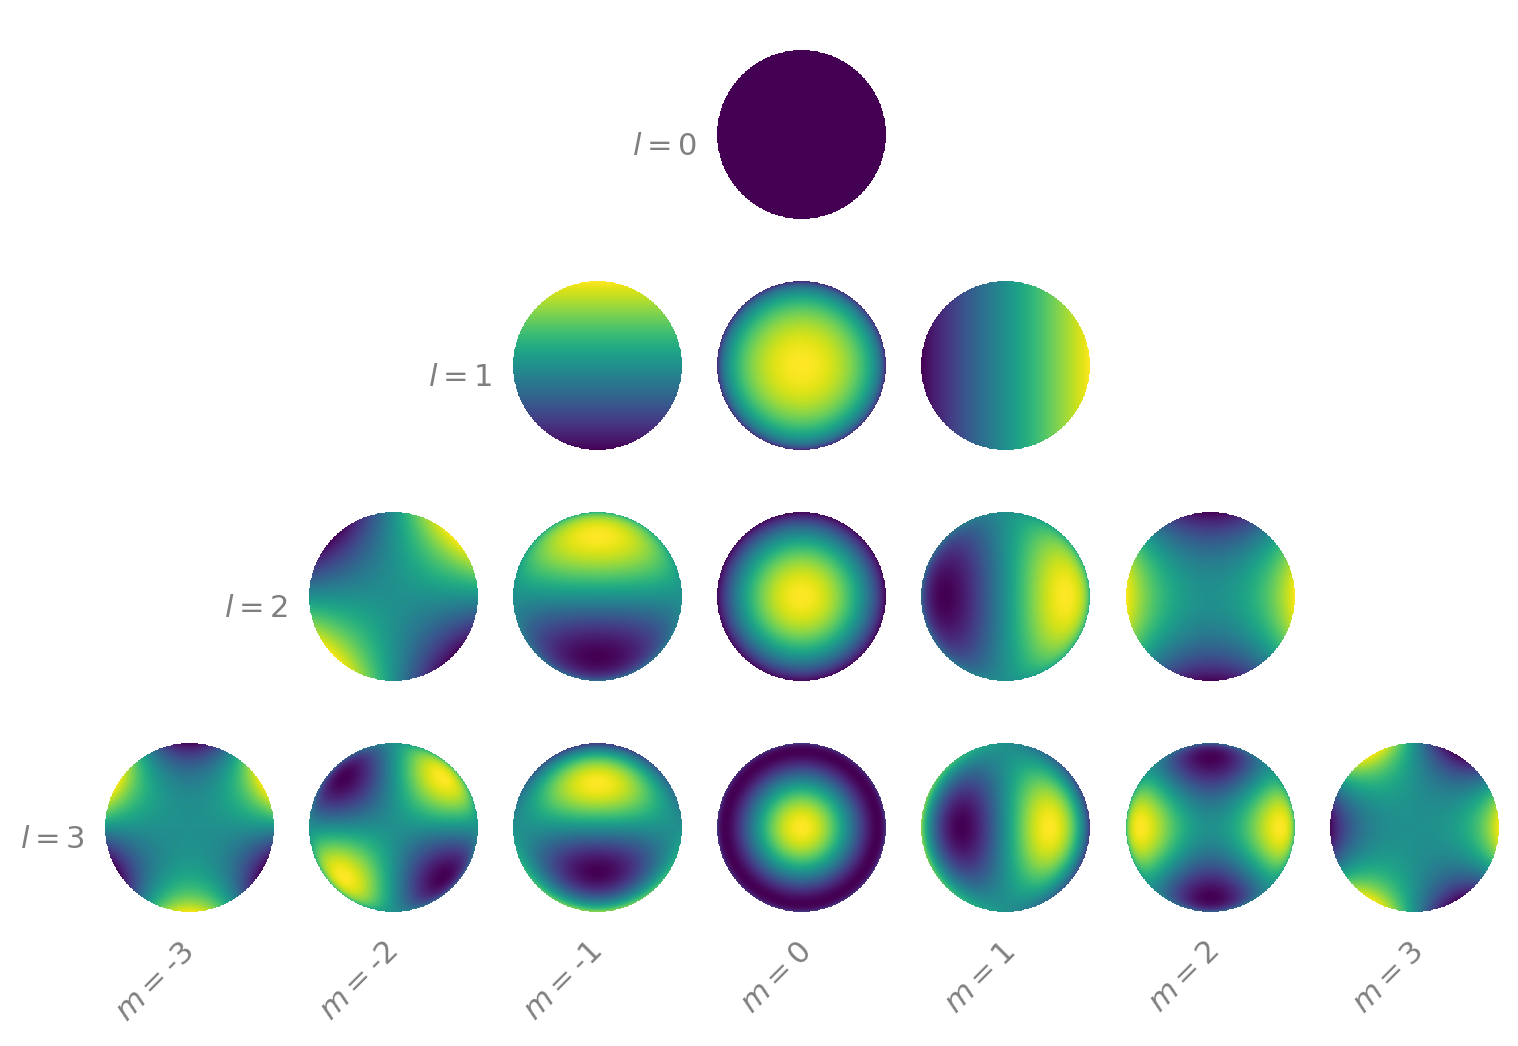

In [5]:
show_ylms(lmax=3, rs=np.inf)

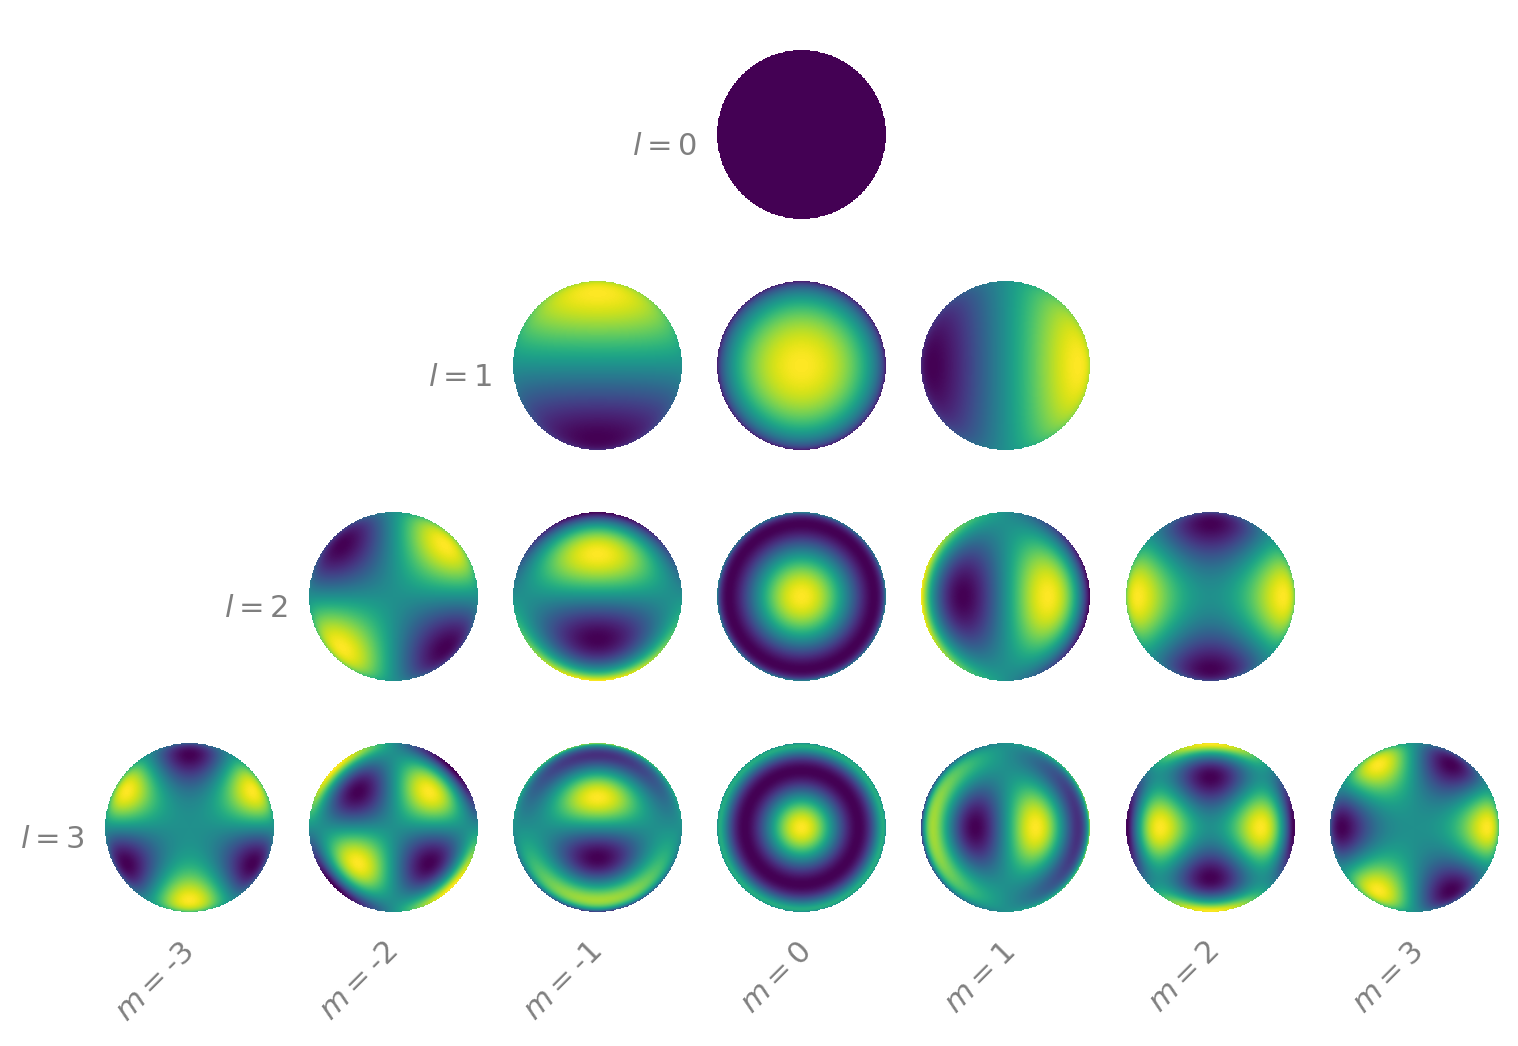

In [6]:
show_ylms(lmax=3, rs=2)

In [7]:
def energy(r, l, theta, rs, vrot=0.3):
    """
    the relation between the energy observed at 
    infinite distance and the emitted energy at the surface
    """
    y = r * np.sin(theta)
    e = 1 - y * vrot * np.sin(theta) + (y**2 - 1/2) * vrot**2 * np.sin(theta)**2 - 1/rs * (1 - (y**2 - 1/2) * vrot**2 * np.sin(theta)**2)
    return e


The energy factor we're interested in here is: 
$$e/e_{surf} = 1 - rv_{rot}\sin{\theta_0} + (r^2 - 1/2)v_{rot}^2\sin{\theta_0^2} - \frac{1}{r_s}(1-(r^2 - 1/2)v_{rot}^2\sin{\theta_0}^2)$$

In [17]:
def intensity(r, l, theta, rs=np.inf):
    """
    Radial intensity of the zonal spherical harmonic of degree `l`
    projected onto the unit disk for a neutron star of radius `rs`
    in units of the Schwarzschild radius.
    """
    t = 2 * (1 - np.sqrt(1 - r**2)) / (r * rs)
    coslat = np.sqrt(1 - r**2) * np.cos(t) - r * np.sin(t)
    return np.sqrt(2 * l + 1) / np.pi * legendre(l)(coslat) * energy(r,l,np.arccos(coslat),rs)

The intensity of the spherical harmonic $Y_{l,0}$ projected onto the disk is

$$
F_l = 2\sqrt{2l + 1}\int_0^1 P_l\left( \sqrt{1 - r^2} \cos \theta(r) - r \sin \theta(r) \right) r dr
$$

where

$$
\theta(r) = 2 \frac{1 - \sqrt{1 - r^2}}{r r_s}
$$

In [18]:
def ylm_integrals(lmax, theta, rs=np.inf):
    """
    Projected intensity integrated over the unit disk.
    This is the flux one would measure from each basis component.
    """
    I = np.zeros((lmax + 1) ** 2)
    for l in range(lmax + 1):
        n = l ** 2 + l
        I[n] = 2 * np.pi * quad(lambda r: r * intensity(r, l, rs), 0, 1)[0]
    return I

In [25]:
def design_matrix(theta, lmax=30, inc=90, rs=np.inf):
    map = starry.Map(lmax)
    rT = ylm_integrals(lmax, theta, rs=rs).reshape(1, -1)
    return map.ops.right_project(
        rT,
        np.array(inc * np.pi / 180),
        np.array(0.0),
        np.atleast_1d(theta) * np.pi / 180,
    )

In [26]:
def flux(theta, y, **kwargs):
    A = design_matrix(theta, **kwargs)
    return A @ y

In [27]:
theta = np.linspace(0, 360, 100)

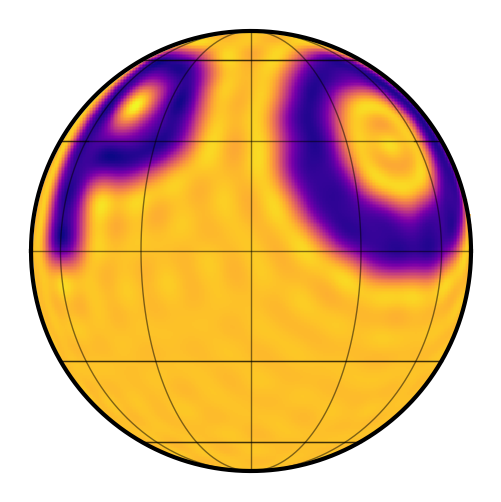

In [28]:
map = starry.Map(30)
map.load("spot")
map.amp = 1
map.show()

In [39]:
map.y

array([ 1.00000000e+00, -1.75688658e-01, -2.09770872e-02,  2.17313714e-03,
        1.71207604e-03, -2.07305746e-02, -4.14703779e-03, -5.43682841e-02,
       -3.97395083e-02, -8.59632292e-02, -8.90131563e-03, -5.72746632e-02,
       -1.93605418e-03,  2.76804225e-03,  2.39146004e-03,  6.73426851e-03,
        1.10629756e-02, -5.01429819e-03,  2.66303102e-02, -2.02508080e-02,
        1.18012353e-01, -2.70009255e-02, -6.59296933e-02, -3.82043914e-02,
        3.07455728e-02,  1.60565927e-02, -1.62779453e-02, -7.41116304e-02,
       -1.09629320e-02,  7.47869659e-02, -1.13594707e-02, -4.00445865e-02,
        3.79579187e-02, -2.38823369e-02, -1.38593146e-03, -4.51436100e-03,
        3.94788664e-03, -2.67037751e-03,  1.35127174e-02,  2.99302935e-02,
       -4.01913999e-02, -1.88589841e-02, -5.24998241e-02, -4.90506101e-02,
       -6.50952980e-03,  1.99732144e-03, -1.22668436e-02, -2.46318476e-02,
       -4.59192306e-02, -5.40285905e-02, -2.69658747e-02, -5.99374603e-03,
        4.88937845e-02,  

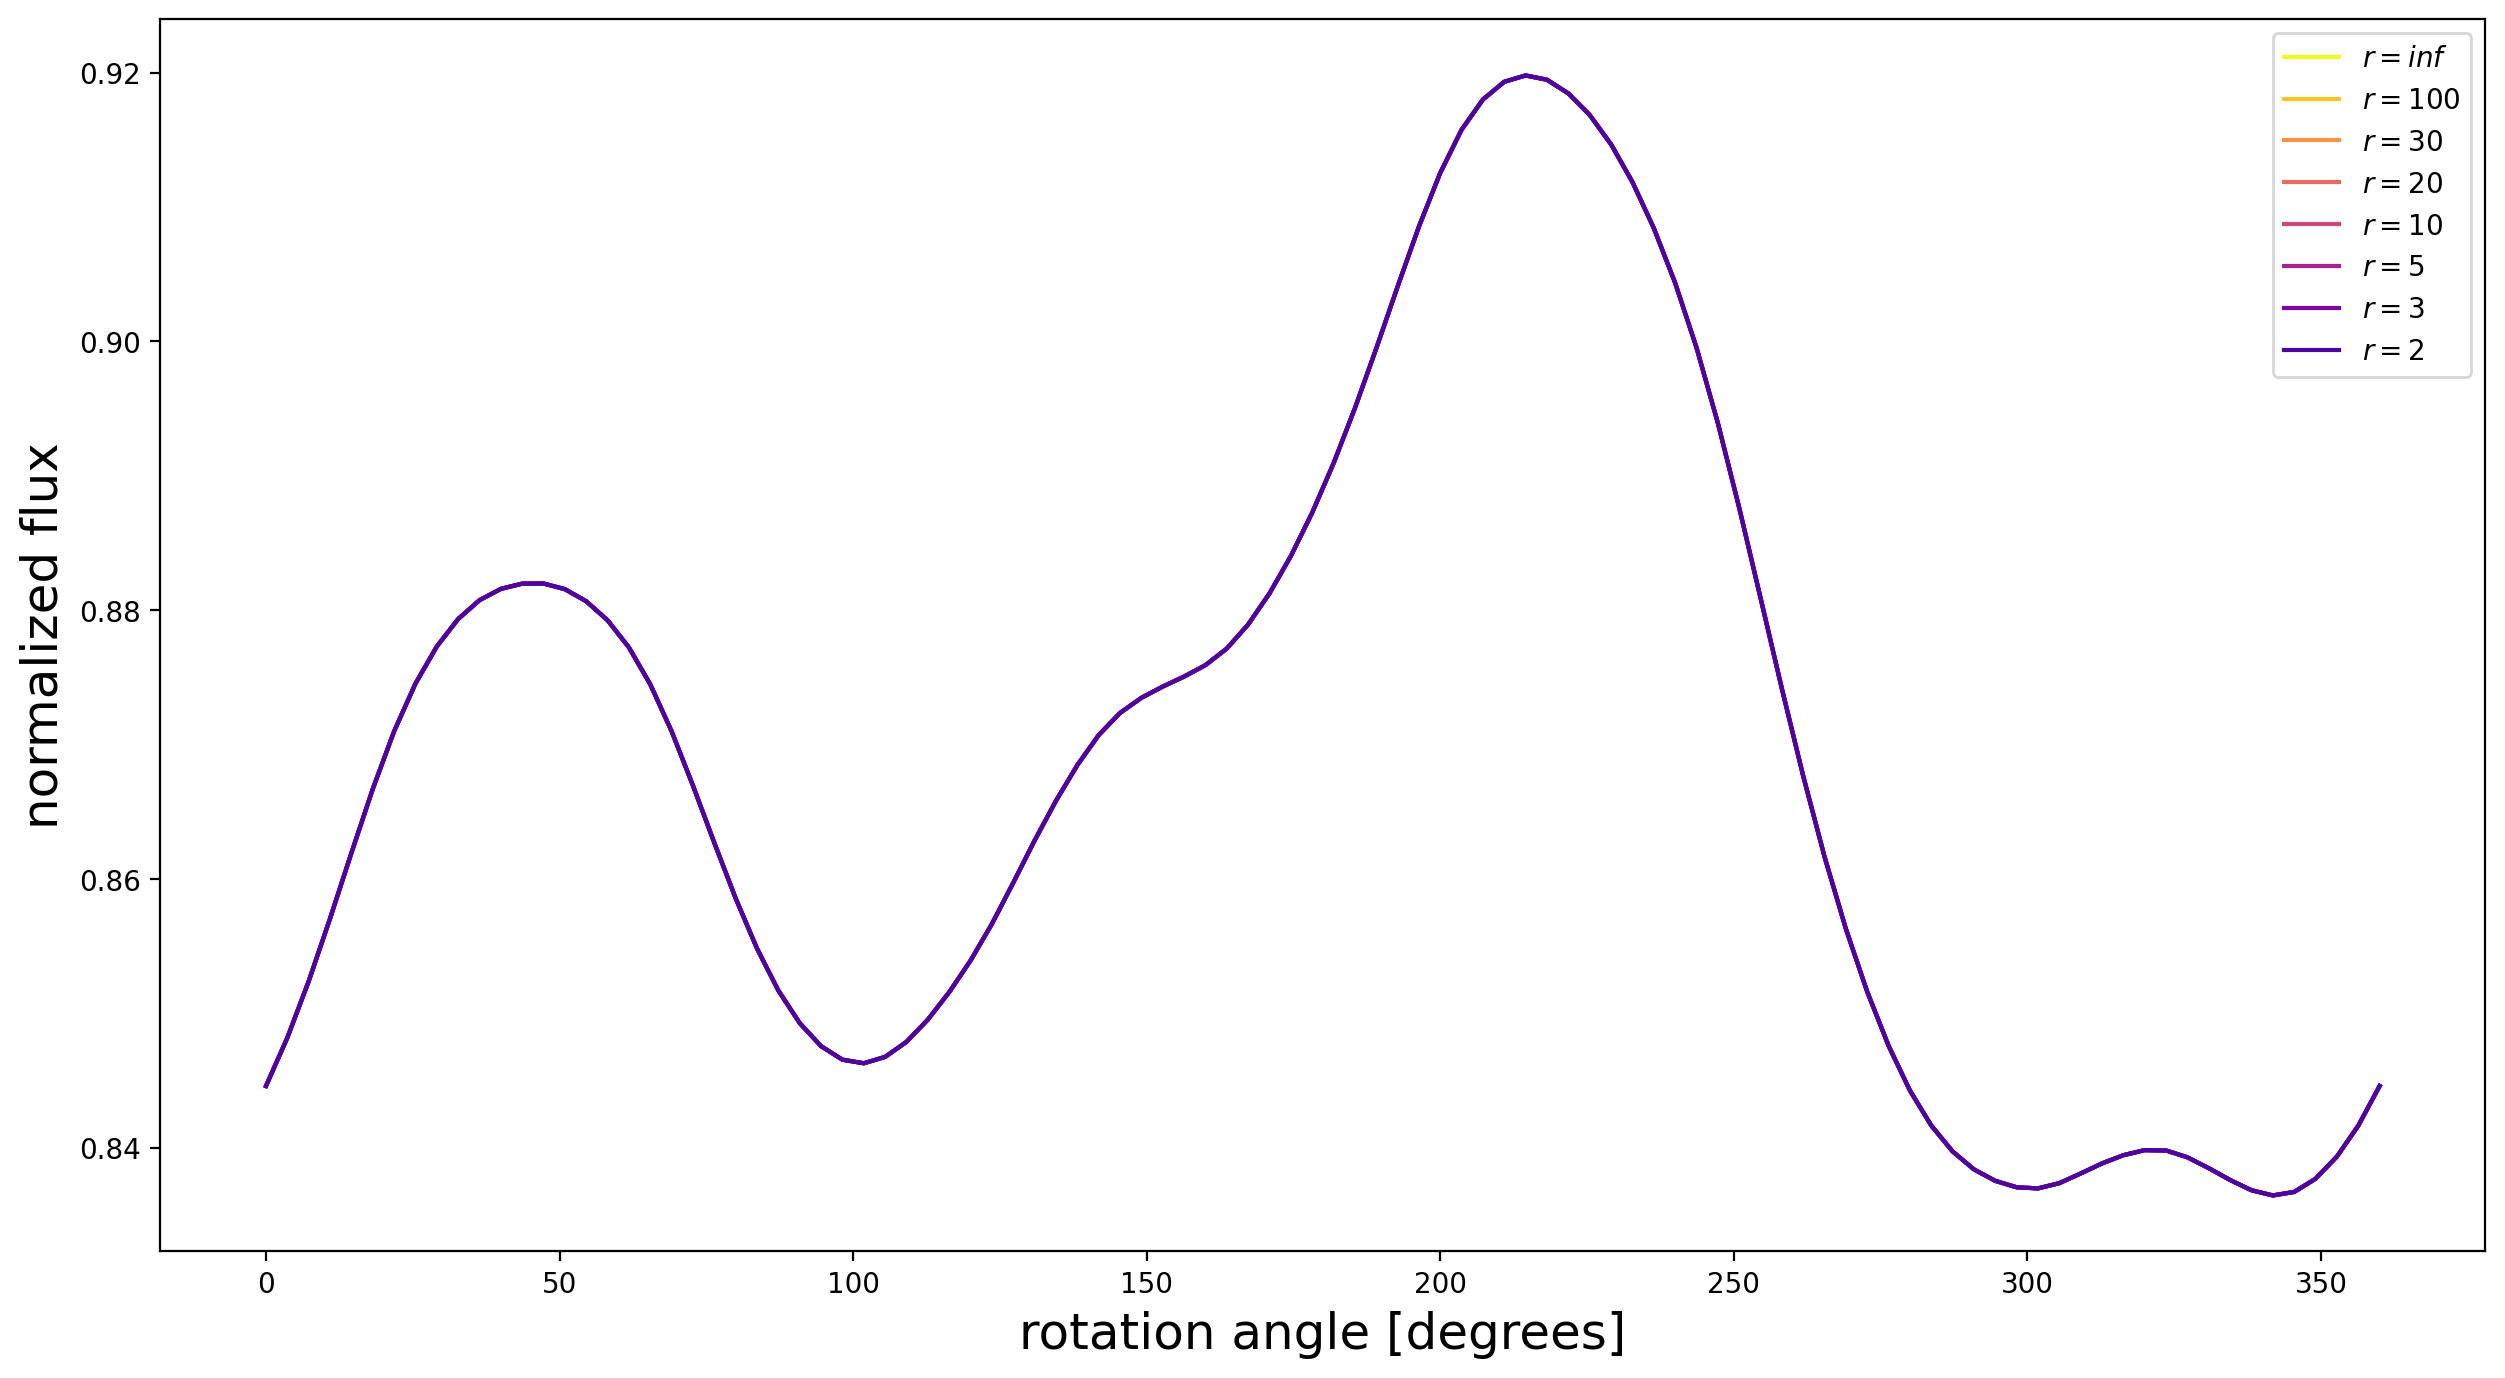

In [34]:
fig, ax = plt.subplots(1, figsize=(15, 8))
cmap = plt.get_cmap("plasma_r")
for n, rs in enumerate([np.inf, 100, 30, 20, 10, 5, 3, 2]):
    plt.plot(theta, flux(theta, map.y, lmax=30, rs=2), label=f"$r={rs}$", color=cmap(n/8))
plt.xlabel("rotation angle [degrees]", fontsize=18)
plt.ylabel("normalized flux", fontsize=18)
plt.legend()

In [16]:
rs = 2
nx = 300

x, y = np.linspace(-1, 1, nx), np.linspace(-1, 1, nx)
x, y = np.meshgrid(x, y)
x = x.flatten()
y = y.flatten()
lat, lon = transform(x, y, rs=rs)
I = np.zeros((len(theta), nx, nx))
for n in range(len(theta)):
    I[n] = map.intensity(lat=lat, lon=lon - theta[n]).reshape(nx, nx)

In [27]:
energy(1, 1, 0, lon, rs=2, P=0)

ZeroDivisionError: float division by zero

In [17]:
map.show(theta=theta, image=I)

RuntimeError: Requested MovieWriter (ffmpeg) not available